In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import IA3Config, get_peft_model, TaskType
from tqdm import tqdm
from matplotlib import pyplot as plt

In [6]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer

In [4]:
from huggingface_hub import login
login()

In [7]:

quantization_config = transformers.BitsAndBytesConfig(load_in_4bit=True)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1", truncation=True, padding=True, padding_side="right")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1", quantization_config=quantization_config)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = prepare_model_for_kbit_training(model)

config = LoraConfig(r = 4,
                    lora_alpha=4,
                    target_modules = ["gate", "w1", "w2", "w3"],
                    lora_dropout=0.1
                    )




Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
lora_model = PeftModel.from_pretrained(
    model, 
    "kaaiiii/Mixtral_LoRA_v2"
)

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/229M [00:00<?, ?B/s]

In [12]:
# print(lora_model)

prompt = "Hello! Please introduce yourself."
inputs = tokenizer(prompt, return_tensors="pt").to(lora_model.device)

with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=60,
        do_sample=True,
        temperature=0.7
    )

print("\n=== Model Output ===")
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== Model Output ===
Hello! Please introduce yourself.
My name is Anastasiia, I’m from Moscow, Russia. I’m a graphic designer, a visual artist and an illustrator. I’m currently working for a company called Kukuhub, we create games for mobile devices. For me, personally, it’


In [19]:
print(lora_model)

PeftModel(
  (base_model): LoraModel(
    (model): MixtralForCausalLM(
      (model): MixtralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MixtralDecoderLayer(
            (self_attn): MixtralAttention(
              (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
            )
            (block_sparse_moe): MixtralSparseMoeBlock(
              (gate): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=8, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_feature

In [30]:
# @owen
import re
import bitsandbytes as bnb

def extract_router_modules(model):
    routers = {}  # { layer_index: gate_module }
    for name, module in model.named_modules():
        if name.endswith("block_sparse_moe.gate"):
            layer = int(re.search(r"layers\.(\d+)\.", name).group(1))
            routers[layer] = module
    return routers


def get_W_from_gate(gate):
    # unwrap lora
    if hasattr(gate, "base_layer"):
        gate = gate.base_layer

    # quantized case
    if hasattr(gate, "quant_state"):
        q = gate.weight.data.view(-1)
        W = bnb.functional.dequantize_4bit(
            q,
            quant_state=gate.quant_state,
            quant_type="nf4"
        ).view(gate.out_features, gate.in_features)
    else:
        W = gate.weight.data

    return W.float()   # (8, 4096)


# --------------------------
# 2. Extract LoRA A and B for all router layers
# --------------------------
def extract_router_lora_AB(model):
    A_dict, B_dict = {}, {}
    
    for name, param in model.named_parameters():
        if "block_sparse_moe.gate.lora_A" in name:
            layer = int(re.search(r"layers\.(\d+)\.", name).group(1))
            A_dict[layer] = param.detach().float()
        elif "block_sparse_moe.gate.lora_B" in name:
            layer = int(re.search(r"layers\.(\d+)\.", name).group(1))
            B_dict[layer] = param.detach().float()

    return A_dict, B_dict

# --------------------------
# 3. Compute W, AB, and W+AB norms
# --------------------------
def compute_router_norms(model, alpha=4, r=4):
    scale = alpha / r

    routers = extract_router_modules(model)
    A_dict, B_dict = extract_router_lora_AB(model)

    norms_W = {}
    norms_AB = {}
    norms_WAB = {}

    for layer, gate in routers.items():

        # ----- W -----
        W = get_W_from_gate(gate)        # (8, 4096)
        norms_W[layer] = torch.norm(W, dim=1).tolist()

        # ----- AB -----
        if layer in A_dict:   # LoRA exists
            A = A_dict[layer]     # (rank, 4096)
            B = B_dict[layer]     # (8, rank)
            delta = scale * (B @ A)  # (8, 4096)
        else:
            delta = torch.zeros_like(W)

        norms_AB[layer] = torch.norm(delta, dim=1).tolist()

        # ----- W + AB -----
        merged = W + delta
        norms_WAB[layer] = torch.norm(merged, dim=1).tolist()

    return norms_W, norms_AB, norms_WAB

norms_W, norms_AB, norms_WAB = compute_router_norms(lora_model)

[2.2971317768096924, 2.435108184814453, 2.315983295440674, 2.1392693519592285, 2.3053276538848877, 2.1504135131835938, 2.478849411010742, 1.999280333518982]


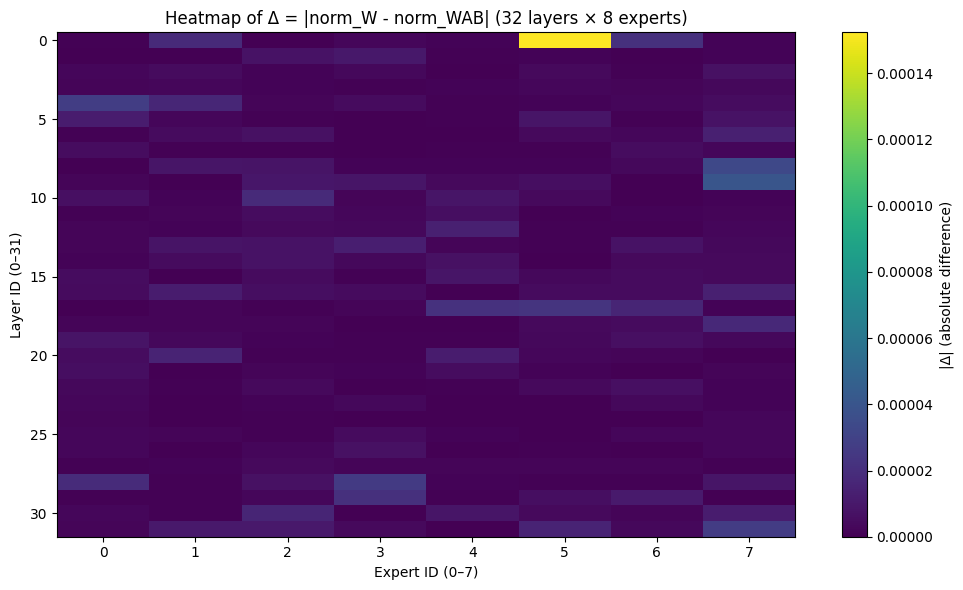

In [34]:
W = np.array([norms_W[i] for i in range(32)])
WAB = np.array([norms_WAB[i] for i in range(32)])

# Compute absolute delta
delta = np.abs(W - WAB)

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(delta, cmap="viridis", aspect="auto")
plt.colorbar(label="|Δ| (absolute difference)")

plt.title("Heatmap of Δ = |norm_W - norm_WAB| (32 layers × 8 experts)")
plt.xlabel("Expert ID (0–7)")
plt.ylabel("Layer ID (0–31)")

plt.tight_layout()
plt.show()

In [35]:
k_values = [1, 2, 3, 4]

results = {}  # store layer → {k: indices}

for layer in range(delta.shape[0]):  # 0..31
    layer_vals = delta[layer]  # shape (8,)
    sorted_idx = np.argsort(layer_vals)  # ascending order, smallest first

    results[layer] = {k: sorted_idx[:k].tolist() for k in k_values}

# print results
for layer in results:
    print(f"Layer {layer}:")
    for k in k_values:
        print(f"  smallest {k}: expert IDs = {results[layer][k]}")

Layer 0:
  smallest 1: expert IDs = [2]
  smallest 2: expert IDs = [2, 0]
  smallest 3: expert IDs = [2, 0, 4]
  smallest 4: expert IDs = [2, 0, 4, 7]
Layer 1:
  smallest 1: expert IDs = [1]
  smallest 2: expert IDs = [1, 0]
  smallest 3: expert IDs = [1, 0, 6]
  smallest 4: expert IDs = [1, 0, 6, 4]
Layer 2:
  smallest 1: expert IDs = [4]
  smallest 2: expert IDs = [4, 6]
  smallest 3: expert IDs = [4, 6, 2]
  smallest 4: expert IDs = [4, 6, 2, 0]
Layer 3:
  smallest 1: expert IDs = [3]
  smallest 2: expert IDs = [3, 4]
  smallest 3: expert IDs = [3, 4, 2]
  smallest 4: expert IDs = [3, 4, 2, 0]
Layer 4:
  smallest 1: expert IDs = [4]
  smallest 2: expert IDs = [4, 5]
  smallest 3: expert IDs = [4, 5, 2]
  smallest 4: expert IDs = [4, 5, 2, 6]
Layer 5:
  smallest 1: expert IDs = [3]
  smallest 2: expert IDs = [3, 4]
  smallest 3: expert IDs = [3, 4, 6]
  smallest 4: expert IDs = [3, 4, 6, 2]
Layer 6:
  smallest 1: expert IDs = [3]
  smallest 2: expert IDs = [3, 4]
  smallest 3: expert

In [36]:
import torch
import torch.nn as nn
from transformers import MixtralForCausalLM, AutoTokenizer
import os
import shutil
from pathlib import Path

# GPU and cache settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_HOME"] = "/workspace/hf_cache"

In [37]:
# empty the cache
torch.cuda.empty_cache()

In [38]:
def check_disk_space(path, required_gb=100):
	"""Check if there's enough disk space available."""
	stats = shutil.disk_usage(path)
	available_gb = stats.free / (2**30)  # Convert to GB
	return available_gb >= required_gb, available_gb

class PrunedMixtralSparseMoeBlock(nn.Module):
	def __init__(self, original_moe, pruned_experts):
		super().__init__()
		self.pruned_experts = sorted(pruned_experts)
		
		# Prune the gate network
		with torch.no_grad():
			original_weight = original_moe.gate.weight
			mask = torch.ones(original_weight.size(0), dtype=torch.bool)
			mask[pruned_experts] = False
			new_weight = original_weight[mask]

		self.gate = nn.Linear(original_moe.gate.in_features, original_moe.gate.out_features - len(pruned_experts), bias=False)
		self.gate = self.gate.to(original_weight.device)
		self.gate.weight.data = new_weight
		
		# Actually remove the pruned experts
		self.experts = nn.ModuleList([expert for i, expert in enumerate(original_moe.experts) if i not in pruned_experts])
		self.num_experts = len(self.experts)

	def forward(self, hidden_states):
		gate_logits = self.gate(hidden_states)
		weights, selected_experts = torch.topk(gate_logits, k=2, dim=-1)
		weights = nn.functional.softmax(weights, dim=-1)
		
		hidden_states = hidden_states.unsqueeze(1)  # Add sequence length dimension
		expert_outputs = torch.zeros_like(hidden_states)
		for i, expert in enumerate(self.experts):
			expert_mask = (selected_experts == i).any(dim=-1).unsqueeze(-1)
			expert_inputs = hidden_states * expert_mask
			expert_outputs += expert(expert_inputs) * expert_mask
		
		hidden_states = hidden_states.squeeze(1)  # Remove sequence length dimension
		expert_outputs = expert_outputs.squeeze(1)
		
		output = torch.einsum("...e,...ec->...c", weights, expert_outputs)
		return output

def prune_mixtral_experts(model, pruned_experts_per_layer):
	for layer_idx, pruned_experts in pruned_experts_per_layer.items():
		original_moe = model.model.layers[layer_idx].block_sparse_moe
		pruned_moe = PrunedMixtralSparseMoeBlock(original_moe, pruned_experts)
		model.model.layers[layer_idx].block_sparse_moe = pruned_moe
	return model

In [41]:
# Check disk space in the HF cache directory
# cache_dir = "/root/.cache/huggingface"
cache_dir = "/root/.cache/huggingface/"
has_space, available_gb = check_disk_space(cache_dir)

if not has_space:
    print(f"Warning: Only {available_gb:.2f}GB available in {cache_dir}")
    response = input("Continue anyway? (y/n): ")
    if response.lower() != 'y':
        print("Aborting operation.")

In [ ]:
print("Loading model...")
model = MixtralForCausalLM.from_pretrained(
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    torch_dtype=torch.float16,  # Use half precision
    device_map="auto"  # Automatically handle multi-GPU
    # device_map=None,
    # low_cpu_mem_usage=False
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1")

Loading model...


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [45]:
for k in [1, 2, 3, 4]:
    print(f"----------------------prune {k} experts---------------------")
    temp_save_dir = Path(f"./temp_model_save_{k}")
    temp_save_dir.mkdir(exist_ok=True)
    
    pruned_experts_per_layer = {}
    for i in range(32):
        pruned_experts_per_layer[i] = results[i][k]

    print("Pruning the model...")
    pruned_model = prune_mixtral_experts(model, pruned_experts_per_layer)
    print("Model pruned!")
    pruned_model = pruned_model.to("cuda")
    
    # Save in chunks first
    print(f"Saving model to temporary directory: {temp_save_dir}")
    pruned_model.save_pretrained(
        temp_save_dir,
        max_shard_size="2GB",
        safe_serialization=True
    )
    tokenizer.save_pretrained(temp_save_dir)

    print("Pushing to Hugging Face Hub...")
    pruned_model.push_to_hub(
        f"kaaiiii/Mixtral_prune_{k}_experts",
        max_shard_size="2GB",
        safe_serialization=True
    )
    tokenizer.push_to_hub(
        f"kaaiiii/Mixtral_prune_{k}_experts",
    )
    print("Successfully pushed to Hub!")

    

----------------------prune 1 experts---------------------
Loading model...


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 